In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexPE"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG16(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(10136, 512)

In [8]:
bnfeatures = np.reshape(bnfeatures,(bnfeatures.shape[0],-1))

In [9]:
bnfeatures.shape

(10136, 512)

In [10]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True, random_state=1)

In [11]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, g

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  6.2min


[CV] .............. C=0.01, gamma=1e-08, score=0.137795, total= 3.6min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.138751, total= 3.6min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.137695, total= 3.6min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.137795, total= 3.6min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.138477, total= 3.6min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.137695, total= 3.8min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.136986, total= 3.9min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  6.7min


[CV] .............. C=0.01, gamma=1e-07, score=0.136986, total= 4.2min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.139442, total= 4.2min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.137795, total= 4.2min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.136986, total= 4.2min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.137695, total= 4.1min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.138889, total= 4.2min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.139442, total= 4.2min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.1min


[CV] .............. C=0.01, gamma=1e-05, score=0.139165, total= 3.9min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.137795, total= 4.0min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.316047, total= 3.8min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.137795, total= 3.9min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.138477, total= 3.9min
[CV] C=0.01, gamma=0.001 .............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.319608, total= 3.8min
[CV] C=0.01, gamma=0.001 .............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.320866, total= 3.9min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 13.3min


[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.331355, total= 3.9min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.314961, total= 4.0min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.139442, total= 4.1min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138889, total= 4.1min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.136986, total= 4.2min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.323092, total= 4.0min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.137695, total= 4.2min
[CV] C

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 18.8min


[CV] .............. C=0.01, gamma=0.001, score=0.471457, total= 3.3min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.473788, total= 3.3min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.468504, total= 3.4min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.489087, total= 3.4min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.482107, total= 3.4min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.480392, total= 3.4min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ............... C=0.01, gamma=0.01, score=0.449803, total= 3.9min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 20.4min


[CV] ............... C=0.01, gamma=0.01, score=0.456888, total= 4.4min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............... C=0.01, gamma=0.01, score=0.447082, total= 4.5min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.465209, total= 4.5min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.452191, total= 4.5min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.322709, total= 4.6min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.399414, total= 5.0min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.379648, total= 5.0min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 25.6min


[CV] ................ C=0.01, gamma=1.0, score=0.367188, total= 4.4min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.349020, total= 4.5min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.351272, total= 4.4min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.367691, total= 4.4min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.355094, total= 4.5min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.359252, total= 5.1min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.362205, total= 5.1min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 31.8min


[CV] ............... C=0.01, gamma=10.0, score=0.362103, total= 4.3min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.351833, total= 4.4min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.136986, total= 3.8min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.137255, total= 3.9min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.137795, total= 3.9min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.372763, total= 4.4min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.354582, total= 4.4min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 36.0min


[CV] ............... C=0.1, gamma=1e-07, score=0.137795, total= 4.6min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.138477, total= 4.6min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.138751, total= 4.7min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.138889, total= 4.7min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.139165, total= 4.7min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.139442, total= 4.7min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.137255, total= 3.9min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 39.8min


[CV] .............. C=0.1, gamma=0.0001, score=0.590820, total= 3.0min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.603718, total= 3.0min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=0.001, score=0.788086, total= 1.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=0.001, score=0.805284, total= 1.5min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.592157, total= 3.0min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=0.001, score=0.782353, total= 1.6min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=0.001, score=0.753937, total= 1.5min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 43.5min


[CV] .............. C=0.1, gamma=0.0001, score=0.605159, total= 2.9min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.600398, total= 2.8min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.339286, total= 4.4min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.603586, total= 2.9min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.616452, total= 3.1min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.790837, total= 1.5min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.796627, total= 1.7min
[CV] C=0.1, gamma=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 48.8min


[CV] ................. C=0.1, gamma=0.1, score=0.581349, total= 3.6min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................. C=0.1, gamma=0.1, score=0.571713, total= 3.5min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................. C=0.1, gamma=1.0, score=0.499023, total= 3.7min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................. C=0.1, gamma=0.1, score=0.575342, total= 4.2min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.544291, total= 4.2min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.550197, total= 4.2min
[CV] ................. C=0.1, gamma=0.1, score=0.546983, total= 4.2min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 54.1min


[CV] ................ C=0.1, gamma=10.0, score=0.483333, total= 4.4min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.476710, total= 3.7min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.462598, total= 4.4min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.486111, total= 3.9min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.495030, total= 3.8min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.470120, total= 3.8min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.138477, total= 3.8min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 60.4min


[CV] ............... C=1.0, gamma=1e-06, score=0.335616, total= 3.8min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.334314, total= 3.9min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.341535, total= 3.8min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.137795, total= 4.7min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.138751, total= 4.8min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.139165, total= 4.7min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.333984, total= 4.8min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 65.0min


[CV] ............... C=1.0, gamma=0.001, score=0.902559, total=  43.8s
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.589463, total= 2.7min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.591633, total= 2.7min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.798220, total= 1.5min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=0.001, score=0.902077, total=  42.4s
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=0.001, score=0.915758, total=  46.1s
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.334985, total= 4.8min
[CV] C=1.0, gamma=0.1 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 68.6min


[CV] ................ C=1.0, gamma=0.01, score=0.884692, total= 2.3min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ................ C=1.0, gamma=0.01, score=0.878097, total= 2.4min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................ C=1.0, gamma=0.01, score=0.882470, total= 2.4min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................ C=1.0, gamma=0.01, score=0.849409, total= 2.7min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................ C=1.0, gamma=0.01, score=0.863095, total= 2.7min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................. C=1.0, gamma=0.1, score=0.771654, total= 3.2min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................. C=1.0, gamma=0.1, score=0.763889, total= 3.2min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 73.6min


[CV] ................. C=1.0, gamma=1.0, score=0.657371, total= 3.4min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.605675, total= 3.4min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.600980, total= 3.7min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.585630, total= 3.7min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.580613, total= 3.3min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.602362, total= 3.4min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.617063, total= 3.4min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed: 80.1min


[CV] .............. C=10.0, gamma=1e-07, score=0.337972, total= 3.9min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.341633, total= 3.9min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.785156, total= 1.4min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.896484, total=  39.3s
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.586614, total= 2.6min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.591176, total= 3.3min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.599804, total= 3.3min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 83.7min


[CV] .............. C=10.0, gamma=0.001, score=0.935421, total=  38.1s
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.918307, total=  33.5s
[CV] C=10.0, gamma=0.01 ..............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.912785, total=  43.0s
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.607532, total= 3.3min
[CV] C=10.0, gamma=0.1 ...............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.901786, total=  42.8s
[CV] C=10.0, gamma=0.1 ...............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.922311, total=  42.2s
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .............. C=10.0, gamma=0.001, score=0.934055, total=  36.0s
[CV] ............. C=10.0, gamma=0.0001, score=0.896620, total=  43.2s
[CV] C

[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed: 88.8min


[CV] ................ C=10.0, gamma=0.1, score=0.784180, total= 3.6min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ................ C=10.0, gamma=1.0, score=0.672549, total= 3.2min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ................ C=10.0, gamma=0.1, score=0.765166, total= 3.6min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ................ C=10.0, gamma=0.1, score=0.758655, total= 3.5min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=1.0, score=0.650591, total= 3.3min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=0.1, score=0.747047, total= 3.6min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=0.1, score=0.759167, total= 3.5min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 96.0min


[CV] ............. C=100.0, gamma=1e-06, score=0.783203, total= 1.3min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.599804, total= 2.8min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.801370, total= 1.3min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.591176, total= 2.8min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.576772, total= 2.8min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.596439, total= 2.8min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.334314, total= 4.7min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 433 tasks      | elapsed: 98.6min


[CV] ............. C=100.0, gamma=1e-05, score=0.892644, total=  46.6s
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.791296, total= 1.2min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.925781, total=  29.2s
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.934442, total=  29.9s
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.787909, total= 1.3min
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.917331, total=  44.2s
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.922549, total=  29.9s
[CV] C=100.0, gamma=0.01 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed: 102.5min


[CV] .............. C=100.0, gamma=0.01, score=0.877349, total= 2.3min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] .............. C=100.0, gamma=0.01, score=0.875992, total= 2.4min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] .............. C=100.0, gamma=0.01, score=0.888008, total= 2.4min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .............. C=100.0, gamma=0.01, score=0.889216, total= 2.6min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .............. C=100.0, gamma=0.01, score=0.893426, total= 2.4min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .............. C=100.0, gamma=0.01, score=0.897614, total= 2.4min
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............... C=100.0, gamma=0.1, score=0.784180, total= 3.2min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 497 tasks      | elapsed: 108.8min


[CV] .............. C=100.0, gamma=10.0, score=0.620040, total= 3.3min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.582031, total= 2.9min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.632207, total= 3.8min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.783203, total= 1.4min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.800391, total= 1.3min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.784314, total= 1.3min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.618526, total= 3.8min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed: 112.1min


[CV] ............ C=1000.0, gamma=1e-05, score=0.915925, total=  34.5s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-06, score=0.906838, total=  41.9s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-06, score=0.888668, total=  41.5s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-06, score=0.897817, total=  47.6s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.587475, total= 2.9min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.596614, total= 2.8min
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.917740, total=  32.1s
[CV] C=1000.0, gamma=0.01 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 121.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03]), 'gamma': array([  1.00000e-08,   1.00000e-07,   1.00000e-06,   1.00000e-05,
         1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [12]:
top_model.cv_results_

{'mean_fit_time': array([ 219.22256756,  219.2330842 ,  225.82524519,  222.68438604,
         223.89528041,  190.97036231,  240.93365028,  255.2265512 ,
         270.33425317,  273.84593899,  220.06015799,  258.72367952,
         224.65480344,  239.06470068,  162.73432367,   82.90451665,
         159.29524739,  219.07063408,  216.54971044,  230.27761111,
         241.29902468,  229.62412565,  245.80857947,  155.10021944,
          70.78603239,   37.63745105,  137.70613642,  203.68985016,
         193.95747731,  204.93992212,  248.2551558 ,  230.97257271,
         170.00548401,   66.66670845,   34.564854  ,   30.80614848,
         137.18986752,  202.11878829,  188.39664605,  194.40817311,
         250.10550611,  158.35660934,   67.99554882,   37.30713153,
          24.5674727 ,   29.46539075,  139.00313578,  197.0339673 ,
         198.1435281 ,  195.72677352,  170.92779126,   70.15728021,
          36.09949362,   27.55270238,   23.42368517,   28.17958083,
         145.04894726,  190.994

In [13]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 9.9999999999999995e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 9.9999999999999995e-07},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 1.0000000000000001e-05},
 mean: 0.32212, std: 0.00471, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.47514, std: 0.00637, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.45511, std: 0.00879, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.39404, std: 0.00935, params: {'C': 0.01, 'gamma': 0.10000000000000001},
 mean: 0.36139, std: 0.00856, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.35625, std: 0.00801, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.13822, std: 0.00079, params: {'C': 0.10000000000000001, 'gamma': 1e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.10000000000000001, 'gamma': 9.9999999999999995e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.10000000000000001, 'gamma': 9.99999999999

In [14]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 100.0, 'gamma': 0.001} - score: 0.9342


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


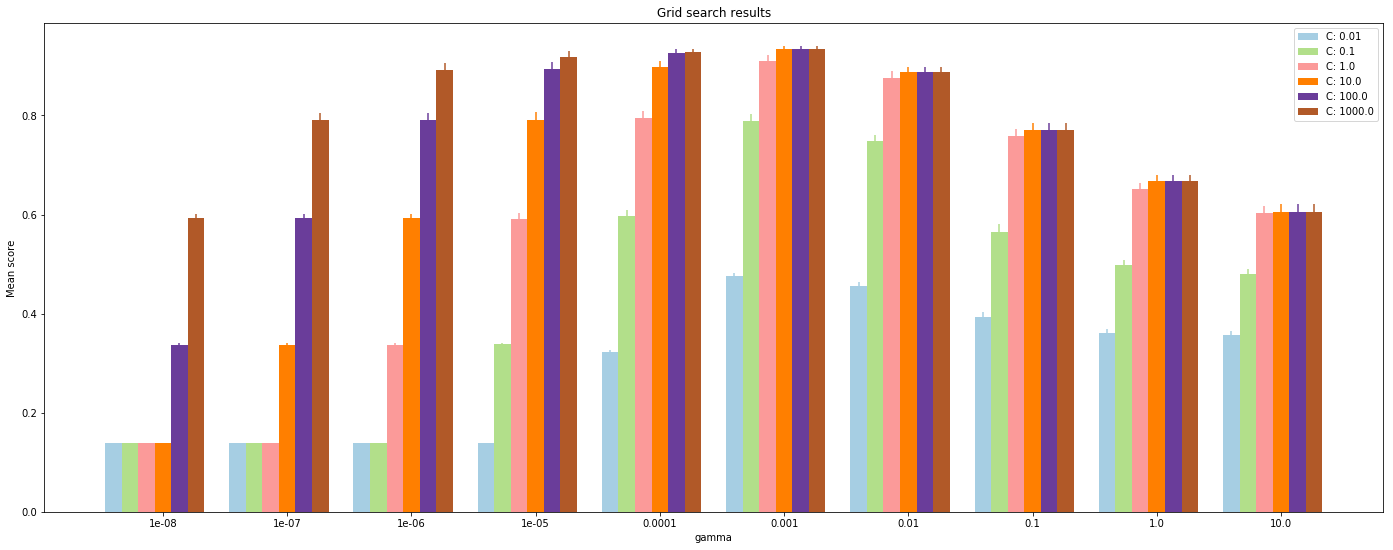

In [15]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()